# Rayleigh Polarization Rendering

This notebook demonstrates polarization rendering of a pure Rayleigh scattering atmosphere. 

---

Related tutorials: 
 - Mie Polarization Rendering.ipynb - rendering of a pure Mie atmosphere.
 - Stcu Polarization Rendering.ipynb - rendering of a stcu cloud withing a Rayleigh atmosphere.

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [58]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import shdom

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
"""
Polarized Rayleigh scattering.
A shdom.Medium object is defined with a homogeneous layer of tau optical depth.
"""
tau = 0.2

nx, ny, nz = 3, 3, 3
rayleigh = shdom.RayleighPolarized(wavelength=0.8)

bounding_box = shdom.BoundingBox(0.0, 0.0, 0.0, 1.0, 1.0, 1.0)
grid = shdom.Grid(bounding_box=bounding_box, nx=3, ny=3, nz=3)

alb_data = np.full(shape=(nx, ny, nz), fill_value=1.0, dtype=np.float32)
ext_data = np.full(shape=(nx, ny, nz), fill_value=tau/nz, dtype=np.float32)
phase_data = np.tile(rayleigh.phase[:, :, np.newaxis, np.newaxis, np.newaxis], (1, 1, nx, ny, nz))

extinction_a = shdom.GridData(grid, ext_data)
albedo_a = shdom.GridData(grid, alb_data)
phase_a = shdom.GridPhaseMatrix(grid, phase_data)

air = shdom.Medium()
air.set_optical_properties(extinction_a, albedo_a, phase_a)

In [27]:
"""
Define the numerical and scene parameters. Several solvers are defined for different solar angles.

Solve the Polarized Radiative Transfer for the domain 
using SHDOM: SOLVE_RTE procedure (src/polarized/shdomsub1.f)
"""
solar_zenith = [180.0, 165.0, 150.0]
solar_azimuth = [0.0, 45.0, 90.0]

numerical_params = shdom.NumericalParameters(deltam=False)

rte_solvers = shdom.RteSolverArray()
for zenith, azimuth in zip(solar_zenith, solar_azimuth):
    scene_params = shdom.SceneParameters(
        wavelength=0.8,
        source=shdom.SolarSource(azimuth, zenith),
        boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                             'x': shdom.BoundaryCondition.periodic},
        surface=shdom.LambertianSurface(albedo=0.0)
    ) 
    solver = shdom.RteSolverPolarized(num_stokes=3, 
                                      scene_params=scene_params, 
                                      numerical_params=numerical_params)
    solver.init_medium(air)
    rte_solvers.add_solver(solver)
    
rte_solvers.solve(maxiter=100)

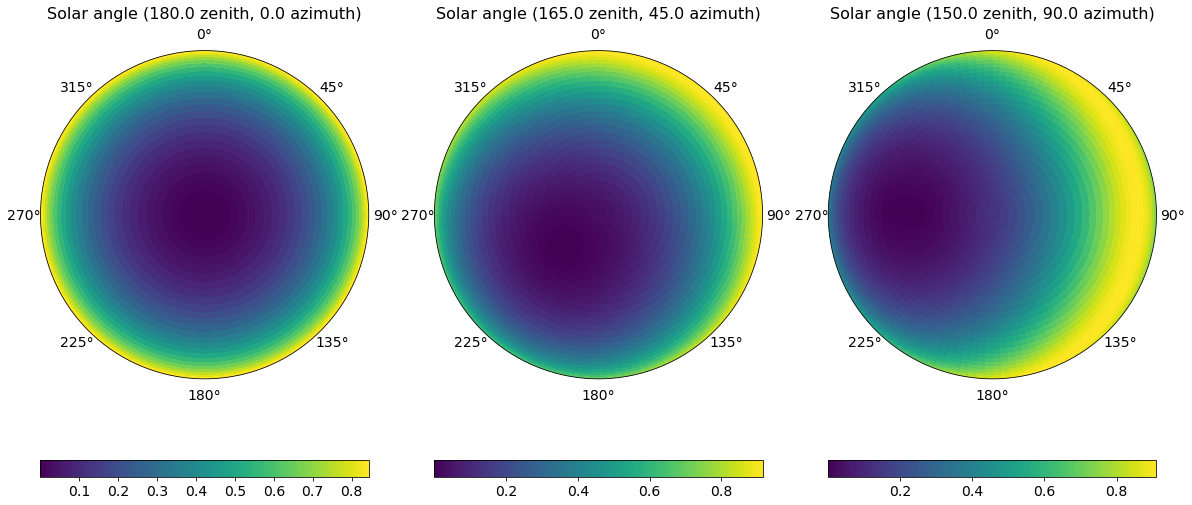

In [78]:
"""
Measure the reflected stokes vector at a single location over a hemisphere of directions.
Polar plot the Degree of Linear Polarization (DoLP) for all atmospheric configurations (solar angles)
"""
camera = shdom.Camera(
    sensor=shdom.DolpAolpSensor(),
    projection=shdom.HemisphericProjection(x=0.5, y=0.5, z=1.0, resolution=3)
)
dolp, aolp = camera.render(rte_solvers, n_jobs=30)

azimuth = camera.projection.phi.reshape(camera.projection.resolution, order='F')
radius = np.sqrt(1-camera.projection.mu**2).reshape(camera.projection.resolution, order='F')
    
%matplotlib inline
num_plots = dolp.shape[-1]
fig = plt.figure(figsize=(20, 10))
for i in range(num_plots):
    ax = plt.subplot(1, num_plots, i+1, projection='polar')
    plt.pcolormesh(azimuth, radius, dolp[...,i])
    plt.title('Solar angle ({} zenith, {} azimuth)'.format(solar_zenith[i], solar_azimuth[i]), 
              fontsize=16, y=1.08)
    cbar = plt.colorbar(orientation='horizontal')
    ax.tick_params(labelsize=14)
    ax.set_yticklabels([])
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    cbar.ax.tick_params(labelsize=14)